In [3]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import gen_data
import qp_solver
import util
import parametric_si 

In [14]:
def compute_c_d(X, a, b, p, lamda):
    dim_beta = p
    dim_z = p - 1
    no_vars = p + 2 * dim_z

    e_1 = lamda * np.hstack((np.zeros(dim_beta), np.ones(2 * dim_z)))
    e_2 = np.hstack((np.dot(X.T, a).flatten(), np.zeros(2 * dim_z)))

    c = e_1 - e_2
    d = np.hstack((-np.dot(X.T, b).flatten(), np.zeros(2 * dim_z)))

    c = c.reshape((no_vars, 1))
    d = d.reshape((no_vars, 1))

    return c, d


In [20]:
def construct_P_q_G_h_A_b(X, y, D, n, p, lamda):
    
    dim_beta = p
    dim_z = p - 1
    no_vars = p + 2 * dim_z

    # construct P
    e_1 = np.hstack((X, np.zeros((n, 2 * dim_z))))
    P = np.dot(e_1.T, e_1)

    # construct q
    e_1 = lamda * np.hstack((np.zeros(dim_beta), np.ones(2 * dim_z)))
    e_2 = np.hstack((np.dot(X.T, y).flatten(), np.zeros(2 * dim_z)))
    q = e_1 - e_2
    q = q.reshape((no_vars, 1))

    # construct G
    G = np.zeros((no_vars, no_vars))
    G[dim_beta:, dim_beta:] = np.zeros((2 * dim_z, 2 * dim_z)) - np.identity(2 * dim_z)

    # construct h
    h = np.zeros((no_vars, 1))

    # construct A
    e_1 = np.hstack((np.identity(dim_z), np.zeros((dim_z, dim_z)) - np.identity(dim_z)))
    A = np.hstack((-D, e_1))

    # construct b
    b = np.zeros((D.shape[0], 1))
    return P, q, G, h, A, b

In [155]:
lambda_seq = np.loadtxt(input_dir+"n_"+str(n)+"_one_d_lambda_choices_delta_"+str(delta)+".csv")
y_data = np.loadtxt(input_dir+"n_"+str(n)+"_new_one_d_sim_test_delta_"+str(delta)+".csv")

In [157]:
lambda_seq[4]

array([38.04592612, 28.18571948])

In [158]:
n = 500
p = n
z_threshold = 20

X = np.identity(n)

D = (np.diag([-1] * n, k=0) + np.diag([1] * (n - 1), k=1))[:-1]

true_y = np.zeros(n)
true_y[100:200] += 2
true_y[250:350] += -2
np.random.seed(1234)
y = true_y + np.random.normal(0, 1, n)

In [210]:
true_changepts = [ 30., 100., 132., 185., 285., 313., 329., 448., 453., 471.]
delta = 5
n_changepts = len(true_changepts)
changepts_aug = np.append(0,np.append(true_changepts,n))
mean_i = 0
underlying_mean = np.zeros(n)

for i in range(n_changepts):
    underlying_mean[int(changepts_aug[i]):int(changepts_aug[i + 1])] = mean_i
    if(mean_i == 0):
        mean_i = delta
    else: 
        mean_i = 0
        
true_y = underlying_mean

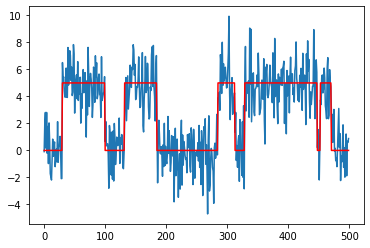

In [225]:
np.random.seed(3214)
y = underlying_mean + np.random.normal(0, 1.5, n)
plt.plot(y)
plt.plot(true_y,color='red')

In [226]:
y = y.reshape((n, 1))
true_y = true_y.reshape((n, 1))
lamda = 55
P, q, G, h, A, b = construct_P_q_G_h_A_b(X, y, D, n, p, lamda)

dim_x = p + 2 * (p - 1)
x, prob = qp_solver.run(P, q, G, h, A, b, dim_x)

x = x.value

beta = x[0:p]
list_cp = util.find_list_cp(beta, p)
print("list cp", list_cp)

list cp [-1, 29, 99, 184, 185, 282, 284, 328, 447, 470, 471, 499]


In [215]:
cp_selected_idx = 6
cp_selected = list_cp[cp_selected_idx]

pre_cp = list_cp[cp_selected_idx - 1]
next_cp = list_cp[cp_selected_idx + 1]
n_s_1 = cp_selected - pre_cp
n_s_2 = next_cp - cp_selected

etaj = np.zeros(n)
etaj[pre_cp + 1 : cp_selected + 1] = np.ones(n_s_1) / n_s_1
etaj[cp_selected + 1 : next_cp + 1] = - np.ones(n_s_2) / n_s_2
etaj = etaj.reshape((n, 1))

etajTy = np.dot(etaj.T, y)[0][0]

a_line, b_line = util.compute_a_b(y, etaj, n)

c, d = compute_c_d(X, a_line, b_line, p, lamda)

path_zk, path_list_cp = parametric_si.run_parametric_si(P, c, d, G, h, A, b, p, dim_x, z_threshold)

tn_mu = np.dot(etaj.T, true_y)[0][0]
cov = np.identity(n)
pivot = util.pivot(list_cp, path_zk, path_list_cp, etaj, etajTy, cov, tn_mu)
print("pivot p value", pivot)

z_interval []
pivot p value None
